In [2]:
#################################################################################################
# Data Processing Module
#
# Converts raw frequency data collected above to a csv file with the following conversions
#      - timestamps -> change in time from start
#      - dmm voltage -> change in frequency 
#      - adds a column for keysight_freq - dmm_freq 
#################################################################################################

import epr_data_collection_rt.kse_experiment_utils as kse
import pandas as pd

ext = ".csv"

##UPDATE FILENAME
## make sure to replace \ with \\ and to remove the .csv from the end
filename_raw = "C:\\Users\\Saam Group\\Desktop\\development\\epr-frequency-shift\\Data\\kseExperiment\\2024-08-07-13_42_06.366510"
filepath_raw = filename_raw + ext
filepath_converted = filename_raw + "_processed"+ext

# second parameter must be one of 'rb85', 'rb87', or 'cs133'
# third parameter must be one of 'high', 'low'
processed_data = kse.processAllData_rt(filepath_raw, 'rb85', 'high')
kse.createCSVProcessedData(filepath_converted, processed_data)




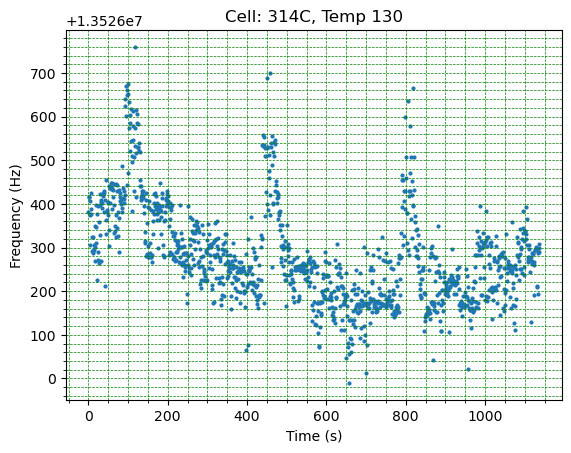

Standard Deviation of Unadjusted Frequecy: 
162.57342167223712
Standard Deviation of Adjusted Frequecy: 
110.2232854432642


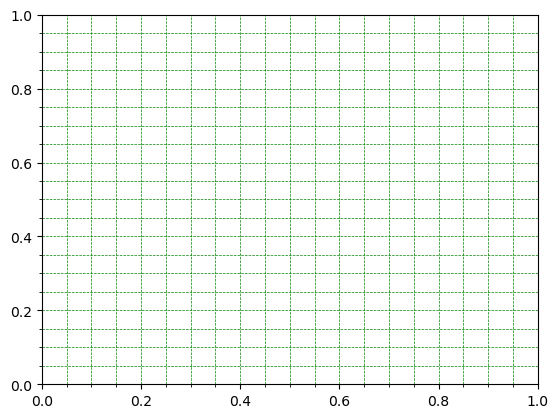

In [53]:
#################################################################################################
# Plot Module
#
# Plots frequency data from converted csv files
#################################################################################################

import pandas as pd
import numpy as np
import src.epr_data_collection_rt.kse_experiment_utils as kse
import matplotlib.pyplot as plt
import numpy as np

dot_size = 2
grid_color = 'green'

def setUpPlot():
    plt.grid(which = 'major', color = grid_color, linestyle = '--', linewidth = '0.5')
    plt.grid(which = 'minor', color = grid_color, linestyle = '--', linewidth = '0.5')
    plt.minorticks_on()

##UPDATE THIS FILEPATH
## remember to replace \ with \\
filepath_processed = 'Data\\kseExperiment\\2024-08-02-15_43_49.788568_processed.csv'
data = pd.read_csv(filepath_processed)

arr_size = len(data['Time'])

times = np.zeros(arr_size)
ks_freq = np.zeros(arr_size)
dmm_freq = np.zeros(arr_size)
dmm_offset = np.zeros(arr_size)
ks_adj = np.zeros(arr_size)
ks_adj1 = np.zeros(arr_size)

for i in range(0, arr_size):
    times[i] = float(data['Time'][i])
    ks_freq[i] = float(data['Keysight'][i])
    dmm_freq[i] = float(data['DMM'][i])
    dmm_offset[i] = dmm_freq[i]+1.352572e7
    ks_adj[i] = float(data['Adjusted Keysight Data'][i])
    ks_adj1[i] = ks_freq[i]+dmm_freq[i]

#use this to remove data at the beginning or end if needed. 
#start_index = 0
#end_index = len(times)-1
#times = times[start_index:end_index]
#ks_freq = ks_freq[start_index:end_index]
#ks_adj = ks_adj[start_index:end_index]
#dmm_freq = dmm_freq[start_index:end_index]
#ks_adj1 = ks_adj1[start_index:end_index]

#Noise Floor things: 
#corrected
stats_corr = kse.getAvgAndStdDev(ks_adj)
std_dev_text_corr = 'Standard Deviation of Adjusted Frequecy: \n' + str(stats_corr[1])
#avg_text_corr = 'Average of Adjusted Frequecy: \n' + str(stats_corr[0])
#info_box_text_corr = std_dev_text_corr + '\n' + avg_text_corr 
#uncorrected
stats_uncorr = kse.getAvgAndStdDev(ks_freq)
std_dev_text_uncorr = 'Standard Deviation of Unadjusted Frequecy: \n' + str(stats_uncorr[1])
#avg_text_uncorr = 'Average of Adjusted Frequecy: \n' + str(stats_uncorr[0])
#info_box_text_uncorr = std_dev_text_uncorr + '\n' + avg_text_uncorr 
#location for standard deviation display on graph
#text_locX = 0.0
#text_locY = 1.35600e7

setUpPlot()

#plt.text(text_locX, text_locY , std_dev_text_corr+'\n'+std_dev_text_uncorr, fontsize = 9, bbox = dict(facecolor = 'white', alpha = 0.5))
#plt.scatter(times, ks_freq, s=dot_size*2, color = 'orange')
#plt.scatter(times, dmm_offset, s=dot_size*3, color='purple')
plt.scatter(times, ks_adj, s=dot_size*2)
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title("Cell: 314C, Temp 130")
#plt.legend(['Raw frequency data', 'DMM frequency'], loc='upper left')

ax = plt.gca()
#ax.set_xlim([xmin, xmax])
#ax.set_ylim([1.35235e7, 1.3529e7])

plt.show()
print(std_dev_text_uncorr)
print(std_dev_text_corr)





In [ ]:
#################################################################################################
# Voltage testing module
# this module connects to the DAQ and creates an analog output task
# that task then sends 2V through the analog output for a few seconds before returning to 0V
# the purpose is to allow for testing of external triggers without having to hook up the actual instruments themselves
#################################################################################################

import nidaqmx
import time


task = nidaqmx.Task()
task.ao_channels.add_ao_voltage_chan("Dev2/ao0")
task.start()
task.write(0.0)#make sure we are starting at 0V
time.sleep(1)

#do one trigger cycle to get rid of the empty data point that apparently gets collected for reasons?
#I hate that this is a thing, but it appears to be a thing, so we're going to roll with it
print("sending 2V now")
task.write(2.0)
time.sleep(5)
task.write(0.0)
time.sleep(1)
task.stop()


#close the DAQ taks
task.close()

In [1]:
#################################################################################################
# Available connections module
# 
# This module lists the available daw connections via the nidaqmx libray and the available 
# instruments via the pyvisa library. Use this to check the names and paths to your instruments
# when setting up data collection. 
#################################################################################################

import nidaqmx.system as sys
import pyvisa as visa

system = sys.System.local()

print('Available daq physical analog output channels: ')
for device in system.devices: 
    print(device.ao_physical_chans.channel_names)

print()

rm = visa.ResourceManager()
res = []
for r in rm.list_resources():
    res.append(r)

print(rm.list_resources_info())

print('Available instrument resources: ')
print(res)
rm.close()


Available daq physical analog output channels: 
['Dev1/ao0', 'Dev1/ao1']
['Dev2/ao0', 'Dev2/ao1']

{'USB0::0x0957::0x1807::MY58430132::INSTR': ResourceInfo(interface_type=<InterfaceType.usb: 7>, interface_board_number=0, resource_class='INSTR', resource_name='USB0::0x0957::0x1807::MY58430132::0::INSTR', alias=None), 'ASRL6::INSTR': ResourceInfo(interface_type=<InterfaceType.asrl: 4>, interface_board_number=6, resource_class='INSTR', resource_name='ASRL6::INSTR', alias='COM6')}
Available instrument resources: 
['USB0::0x0957::0x1807::MY58430132::INSTR', 'ASRL6::INSTR']
